## How to Make a Very Very Bad SPM

### What is an SPM?

Statistical Plus Minus (SPM) are models based on box score data (usually) that attempt to predict a player's RAPM, or [Regularized Adjusted Plus Minus](https://github.com/rd11490/NBA_Tutorials/tree/master/rapm). While RAPM is a somewhat unbiased estimate of a player's +/- value, an SPM can help understand *why* a player might have that +/- value based on their constituent box score components. SPMs you might have heard of include but are not limited to [Daniel Myers](https://twitter.com/DSMok1)' [BPM](https://www.basketball-reference.com/about/bpm.html) and [Jacob Goldstein's](https://twitter.com/JacobEGoldstein)  [PIPM](https://www.bball-index.com/current-pipm/) (Although PIPM contains some non-SPM style lineup information). SPMs are traditionally based in a standard linear regression framework, and do not necessarily need the possession or stint level information needed for calculating RAPM.

import pandas as pd

## What is an SPM not?

**SPMs are not explicit rankings of players.**

## Data

There are two datasets that you will need in order to follow along with this tutorial, both are in the 'data' folder. The RAPM file just has player identification and three year RAPM, and the box scores has player identification and three year box score totals.

1) RAPM (three_year_rapm.csv) via [Ryan Davis the public RAPM king](http://nbashotcharts.com/rapm3?id=-357354019)
2) Box Scores (three_year_box_scores.csv) via NBA.com (only with players > 100 minutes)

## Step 1: Getting the data set up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Read in and convert everything to per 48 minutes
box = pd.read_csv("data/three_year_box_scores.csv")
for col in box.columns:
    if col != 'player_name' and col != 'player_id' and col != 'min':
        box[col] = 48 * (box[col]/box['min'])

rapm = pd.read_csv("data/three_year_rapm.csv")


## Join the data together based on player id
spm_data = box.merge(rapm, on="player_id", how="left")

## Let's see what the column names are
print(spm_data.columns)

Index(['player_id', 'player_name', 'pts', 'fgm', 'fga', 'fg3m', 'fg3a', 'fg2m',
       'fg2a', 'ftm', 'fta', 'reb', 'oreb', 'dreb', 'ast', 'stl', 'tov', 'blk',
       'pf', 'min', 'RAPM'],
      dtype='object')


## Step 2: Setting up the model

At this point the data is ready for modeling. Something to keep in mind is that we only have 630ish observations - not exactly a huge dataset. Let's do an extremely naive attempt with all our data first, just for proof of concept. Because we don't have much data, let's try a leave one out cross validation to see what the range of coefficient values turn out to be. Also, we'll weight our regression by total minutes, since we want to make sure we're more correct on the players that play often.



In [2]:
from sklearn.linear_model import LinearRegression

players = spm_data['player_id'].tolist()

box_score_components = ["pts", "fgm", "fga", "fg3m", "fg3a","fg2m", "fg2a", "ftm", "fta", "reb","oreb", "dreb", "ast", "stl", "tov", "blk", "pf"]

coeff_frame = pd.DataFrame({})

for player in players:
    training_data = spm_data.loc[spm_data['player_id'] != player]
    x_train = training_data[box_score_components]
    y_train = training_data['RAPM'].to_numpy()
    w_train = training_data['min'].to_numpy()

    testing_data = spm_data.loc[spm_data['player_id'] == player]
    x_test = testing_data[box_score_components]
    y_test = testing_data['RAPM'].to_numpy()
    w_test = testing_data['min'].to_numpy()
    
    model = LinearRegression().fit(x_train, y_train, w_train)
    coeff_frame = coeff_frame.append(pd.DataFrame([model.intercept_] + model.coef_.tolist()).T)
    
coeff_frame.columns = ['Intercept'] + box_score_components
coeff_frame.head()

,Intercept,pts,fgm,fga,fg3m,fg3a,fg2m,fg2a,ftm,fta,reb,oreb,dreb,ast,stl,tov,blk,pf
0,-5.233207,0.613613,0.064443,-0.346837,0.208448,-0.126491,-0.144005,-0.220346,0.276278,-0.367579,0.185189,0.305416,-0.120227,0.455255,1.359944,-0.902812,0.613704,-0.199890
0,-5.305279,0.613215,0.064392,-0.343603,0.217964,-0.129033,-0.153572,-0.214570,0.266467,-0.360158,0.183381,0.292116,-0.108735,0.461098,1.356164,-0.935291,0.618008,-0.189062
0,-5.252305,0.613859,0.064975,-0.346141,0.215059,-0.127997,-0.150085,-0.218144,0.268850,-0.360876,0.185998,0.307736,-0.121738,0.457894,1.364895,-0.913847,0.617948,-0.198764
0,-5.228872,0.615604,0.064945,-0.348227,0.216487,-0.129924,-0.151542,-0.218303,0.269228,-0.362659,0.184512,0.304306,-0.119794,0.456057,1.365186,-0.908388,0.618568,-0.198150
0,-5.249161,0.614433,0.065177,-0.347023,0.214554,-0.128378,-0.149377,-0.218644,0.269526,-0.362075,0.184905,0.304409,-0.119504,0.456812,1.362000,-0.910342,0.616578,-0.196453


Whoops. Those are a few insane coefficients. While R throws some warnings when this happens, it appears sklearn does not (I did not know this!). However, totally implausible coefficients in linear regression or are often due to collinearity between features. Here's a quick way to take a look at correlations between your variables, where blue is negative and red is positive.

<AxesSubplot:>

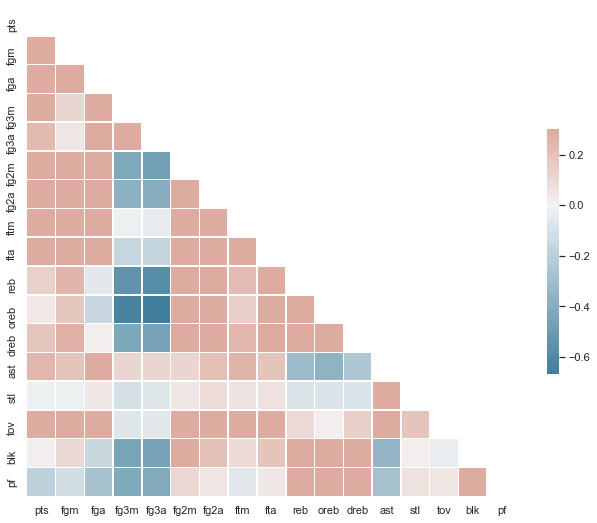

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
## code via https://seaborn.pydata.org/examples/many_pairwise_correlations.html
## ggplot for life

sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(11, 9))
cor_mat = spm_data[box_score_components].corr()
mask = np.triu(np.ones_like(cor_mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(cor_mat, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Let's try again but remove some of the NA'd variables or the summations such as total rebounds.  Colinearity in SPM models is an enormous issue and something that should be handled with some thought, not just by blindly hacking out variables. Now lets blindly hack out some variables.


In [4]:
from sklearn.linear_model import LinearRegression

players = spm_data['player_id'].tolist()

box_score_components = ["pts", "fgm", "fga", "fg3m", "fg3a", "fta","oreb", "dreb", "ast", "stl", "tov", "blk", "pf"]

coeff_frame = pd.DataFrame({})
pred_list = []

for player in players:
    training_data = spm_data.loc[spm_data['player_id'] != player]
    x_train = training_data[box_score_components]
    y_train = training_data['RAPM'].to_numpy()
    w_train = training_data['min'].to_numpy()

    testing_data = spm_data.loc[spm_data['player_id'] == player]
    x_test = testing_data[box_score_components]
    y_test = testing_data['RAPM'].to_numpy()
    w_test = testing_data['min'].to_numpy()
    
    model = LinearRegression().fit(x_train, y_train, w_train)
    coeff_frame = coeff_frame.append(pd.DataFrame([model.intercept_] + model.coef_.tolist()).T)
    pred_list.append(model.predict(x_test).item())
    
coeff_frame.columns = ['Intercept'] + box_score_components
coeff_frame.head()
spm_data['pred_RAPM'] = pred_list
spm_data['resid'] = spm_data['pred_RAPM'] - spm_data['RAPM']

Alright, so it looks good in the sense that there are no NAs or squirrely/impossible values. Now, let's take a look at the distribution of each coefficient just for another sanity check.

In [5]:
coeff_dist = coeff_frame.apply(lambda x: [np.mean(x), np.std(x)]).T
coeff_dist.columns = ["mean_coeff", "sd_coeff"]
coeff_dist

,mean_coeff,sd_coeff
Intercept,-5.251335,0.035144
pts,0.883475,0.013839
fgm,-0.622565,0.030999
fga,-0.565475,0.005287
fg3m,0.093058,0.028851
fg3a,0.091027,0.010267
fta,-0.361645,0.011401
oreb,0.489497,0.006898
dreb,0.065379,0.002872
ast,0.456877,0.003307


Seems to be reasonable. Now, onto the predictions. Keep in mind that this is a Very Very Bad SPM (VVBPM), and not something that you should use. However, these results are generally in the right shape. Note that I hate plotting in python!

<AxesSubplot:xlabel='RAPM', ylabel='pred_RAPM'>

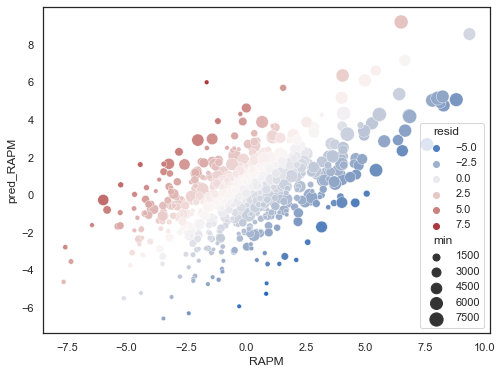

In [6]:
f, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(
    data=spm_data, x="RAPM", y="pred_RAPM", hue="resid", 
    size="min", palette=sns.color_palette("vlag", as_cmap=True),
    sizes=(20, 200)
)

Since a point prediction alone isn’t as useful as a distribution plus a point prediction, here’s a way to get some semblance of a distribution. Essentially sampling from the coefficient distributions to Monte Carlo some predictions. Just kind of a quick and dirty method.

In [8]:
from scipy import stats
stats.norm.rvs(size = 100)

coeff_trials = coeff_dist.apply(lambda x: stats.norm.rvs(size=100, loc=x[0], scale=x[1]),
                               axis = 1)

def spm_function(x):
    res = x[0] + x[1]*pts + x[2]*fgm + x[3]*fga + x[4]*fg3m 
    + x[5]*fg3a + x[6]*fta + x[7]*oreb
    + x[8]*dreb + x[9]*ast + x[10]*stl 
    + x[11]*tov + x[12]*blk + x[13]*pf
    return res

player_spm_frame = pd.DataFrame({})

for player in players:
    player_data = spm_data.loc[spm_data['player_id'] == player]
    player_data = player_data[box_score_components]
    player_data = player_data.values.tolist()[0]
    pts = player_data[0]
    fgm = player_data[1]
    fga = player_data[2]
    fg3m = player_data[3]
    fg3a = player_data[4]
    fta = player_data[5]
    oreb = player_data[6]
    dreb = player_data[7]
    ast = player_data[8]
    stl = player_data[9]
    tov = player_data[10]
    blk = player_data[11]
    pf = player_data[12]
    player_coeff_trials = pd.DataFrame(var for var in coeff_trials)
    player_spm_values = player_coeff_trials.apply(spm_function, axis=0)
    player_spm_frame = player_spm_frame.append(pd.DataFrame({"player_id": [player],
                                                             "mean_spm": [np.mean(player_spm_values)],
                                                             "sd_spm": [np.std(player_spm_values)]}))

spm_results = spm_data.merge(player_spm_frame, on = "player_id", how = "left")
spm_results = spm_results[['player_name', 'mean_spm', 'sd_spm', 'RAPM']]
spm_results = spm_results.sort_values('mean_spm', ascending=False)
spm_results.head(20)

,player_name,mean_spm,sd_spm,RAPM
129,James Harden,9.030729,0.639514,6.49
132,Stephen Curry,6.166408,0.607314,9.35
215,Isaiah Thomas,5.667002,0.573939,0.01
339,Joel Embiid,5.528828,0.604405,6.36
76,Kevin Durant,5.300270,0.587879,4.97
194,Kawhi Leonard,5.103933,0.591381,5.43
291,Giannis Antetokounmpo,4.728108,0.580038,8.80
224,Damian Lillard,4.661146,0.558000,8.02
219,Anthony Davis,4.384731,0.620144,4.04
59,Lou Williams,4.326465,0.536773,0.67


And now you have a Very Very Bad SPM with a smidge of distributions in the predictions (mostly due to uncertainty in the data due to LOOCV). Again, this should be an extremely early starting point. You can add more or less whatever you want to create a good SPM. Go check out the writeups for [BPM 2.0](https://www.basketball-reference.com/about/bpm2.html) and [PIPM](https://fansided.com/2018/01/11/nylon-calculus-introducing-player-impact-plus-minus/) to see how those are made.  